# Predict Sales for a Catalog Launch

### By Sooyeon Won

## Table of Contents
<ul>
<li><a href="#Intro">Introduction</a></li>
<li><a href="#Preparation">Data Preparation</a></li>
<li><a href="#Exploration">Data Exploration</a></li>
<li><a href="#Analysis">Data Analysis</a></li>
<li><a href="#Conclusion">Conclusion</a></li>
</ul>

<a id='Intro'></a>
## Introduction

In this project, I analyze a business problem in the mail-order catalog business. This company manufactures and sells high-end home goods. Last year, the company sent out its first print catalog, and is preparing to send out this year's catalog in the coming months. The company has 250 new customers from their mailing list that they want to send the catalog to. 

Management want make a decision based on the expected profits from sending a catalog to these customers. They do not want to send the catalog out to these new customers unless the expected profit contribution exceeds $10,000. I am tasked with predicting how much money the company can expect to earn from sending out a catalog to new customers.

 **Analysis Steps:** <br>
To calculate expected profits, first we need to figure out the features, correlated with the average sales amounts, based on the existing customer data. Then we build the predictive model with the features to predict the average sales amount of the new customers.
By multiplying the predicted sales amount with the probability that each new customer will buy our catalog, we can get the information of the expected revenue from these 250 people. Then the aggregated revenue should be multiplied with the average gross margin. Next, the total costs of catalog for 250 customers should be subtracted. Finally, we need to compare the total expected net profit with the cut-off ($10,000) provided by management. If the total expected profit contribution is larger than the cut-off value, sending this year ‘s catalog to the new customers is recommended.

<a id='Preparation'></a>
## Data Preparation 

In [1]:
# Import the relevant libraries 
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression 
import seaborn as sns 
sns.set()


In [2]:
# Read the data 
raw_data = pd.read_excel('p1-customers.xlsx')

In [3]:
raw_data.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,227.90,100,No,1,6
1,Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,55.00,105,Yes,1,6
2,Jessica Rinehart,Store Mailing List,8,7225 S Gaylord St,Centennial,CO,80122,212.57,101,No,1,3
3,Nancy Clark,Store Mailing List,9,4497 Cornish Way,Denver,CO,80239,195.31,105,Yes,1,6
4,Andrea Brun,Store Mailing List,10,2316 E 5th Ave,Denver,CO,80206,110.55,100,Yes,1,2


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Name                        2375 non-null   object 
 1   Customer_Segment            2375 non-null   object 
 2   Customer_ID                 2375 non-null   int64  
 3   Address                     2375 non-null   object 
 4   City                        2375 non-null   object 
 5   State                       2375 non-null   object 
 6   ZIP                         2375 non-null   int64  
 7   Avg_Sale_Amount             2375 non-null   float64
 8   Store_Number                2375 non-null   int64  
 9   Responded_to_Last_Catalog   2375 non-null   object 
 10  Avg_Num_Products_Purchased  2375 non-null   int64  
 11  #_Years_as_Customer         2375 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 222.8+ KB


In [5]:
raw_data.shape

(2375, 12)

In [6]:
sum(raw_data.Customer_ID.duplicated()) # All Customer IDs are unique. 

0

In [7]:
raw_data.Customer_Segment.value_counts() # There are 4 types of customer segments.

Store Mailing List              1108
Loyalty Club Only                579
Credit Card Only                 494
Loyalty Club and Credit Card     194
Name: Customer_Segment, dtype: int64

In [8]:
raw_data.State.value_counts() # All customers live in the same state. This column is not informative.

CO    2375
Name: State, dtype: int64

In [9]:
raw_data.City.unique()

array(['Denver', 'Greenwood Village', 'Centennial', 'Lakewood', 'Arvada',
       'Broomfield', 'Aurora', 'Englewood', 'Westminster', 'Northglenn',
       'Littleton', 'Parker', 'Superior', 'Thornton', 'Brighton',
       'Golden', 'Wheat Ridge', 'Castle Pines', 'Highlands Ranch',
       'Edgewater', 'Commerce City', 'Boulder', 'Morrison', 'Lafayette',
       'Louisville', 'Henderson', 'Lone Tree'], dtype=object)

In [10]:
len(raw_data.City.unique()) # Customers are living in 27 different cities.

27

In [11]:
len(raw_data.Store_Number.unique()) # There are 10 different stores. 

10

In [12]:
data = raw_data.copy()
data.drop(['Name','Address', 'State','ZIP'], axis = 1, inplace= True)

In [13]:
data.head()

,Customer_Segment,Customer_ID,City,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Store Mailing List,2,Denver,227.90,100,No,1,6
1,Store Mailing List,7,Greenwood Village,55.00,105,Yes,1,6
2,Store Mailing List,8,Centennial,212.57,101,No,1,3
3,Store Mailing List,9,Denver,195.31,105,Yes,1,6
4,Store Mailing List,10,Denver,110.55,100,Yes,1,2


>- The customer dataset is consisted of 2,375 datapoints and 12 features, The dataset doesn't contain missing values nor duplicated records. 
>- There are 4 types of customer segments.“Name” and “Customer_ID” are simply for identifying the customers. Customers live in the same state but different cities. 
>- Name, Address, State, ZIP: These features are dropped in this stage, since they are not informative for this analysis.

<a id='Exploration'></a>
## Data Exploration 

### 1. Customer Segmment

Text(0.5, 1.0, 'The Number of Customers in Each Segment')

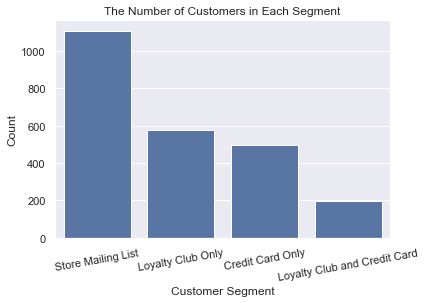

In [14]:
base_color =sns.color_palette()[0]
stage_order = data.Customer_Segment.value_counts().index
sns.countplot(data = data, x = 'Customer_Segment', color = base_color, order = stage_order)
plt.xlabel('Customer Segment')
plt.ylabel('Count')
plt.xticks(rotation =10)
plt.title('The Number of Customers in Each Segment')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

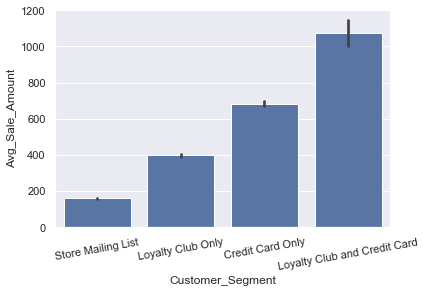

In [15]:
segment_order = data.Customer_Segment.value_counts().index
sns.barplot(data = data, x = 'Customer_Segment', y = 'Avg_Sale_Amount',color = base_color, order = segment_order)
plt.xticks(rotation =10)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

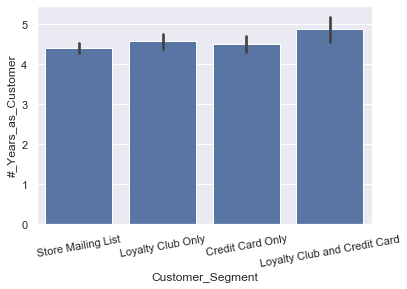

In [16]:
segment_order = data.Customer_Segment.value_counts().index
sns.barplot(data = data, x = 'Customer_Segment', y = '#_Years_as_Customer',color = base_color, order = segment_order)
plt.xticks(rotation =10)

> Customers are categorized into 4 segments: The names of each segment indicate the different levels of customer loyalty.  The number of customers decreases as they belong to higher loyalty group. On the other hand, the average sales amount increases as the customers belong to higher loyalty club. As shown in the first two plots, While the number of "Store Mailing List" customers are the most, their spending is the lowest. Although small number of customers are belonging to "Loyalty Club and Credit Card", their spendings are the largest. Note that the number of years as customer doesn't seem necessary related to customer loyalty. For these reasons, I conclude that customer loyalty is highly related to customers' purchases amount. I included the variable:"Customer_Segment" into the final predictive model.

### 2. Store Number 

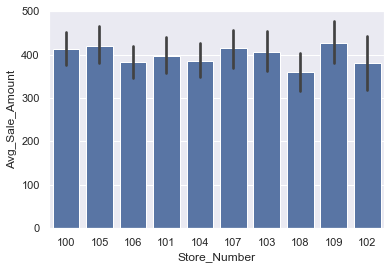

In [17]:
store_order= data.Store_Number.value_counts().index
sns.barplot(data = data, x = 'Store_Number', y = 'Avg_Sale_Amount',color = base_color , order = store_order)

> Then I compare the average sales amount across all stores. None of stores show extraordinary sales amounts. This result seems reasonable since under the same brand have the same products, design and service level, it can be expected that there will be little difference on customers’sales amounts across the stores. This fact can be also proven through regression analysis by transforming the stores into dummies, then run the regression. As expected, none of the dummies are statistically significant with the target variable. Thus, we can conclude that the stores do not have an effect on average sales amounts. This feature is not included in the final model.

### 3. City

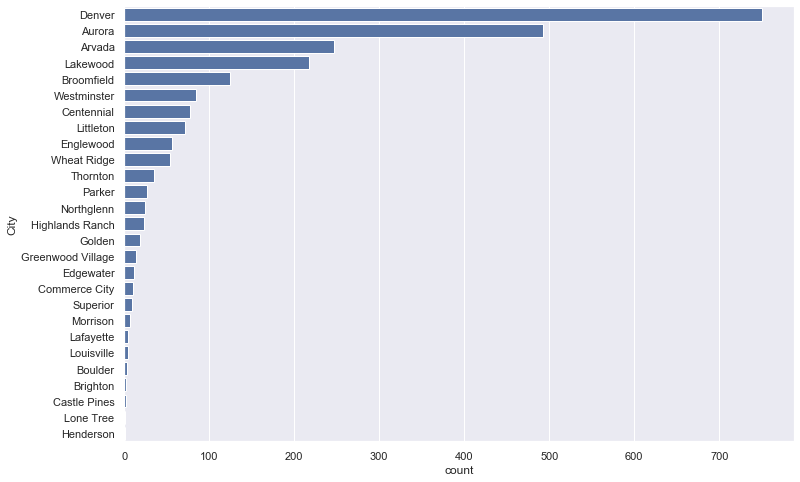

In [18]:
plt.figure(figsize=(12,8))
city_order = data.City.value_counts().index
sns.countplot(data = data, y = 'City', color = base_color, order = city_order)

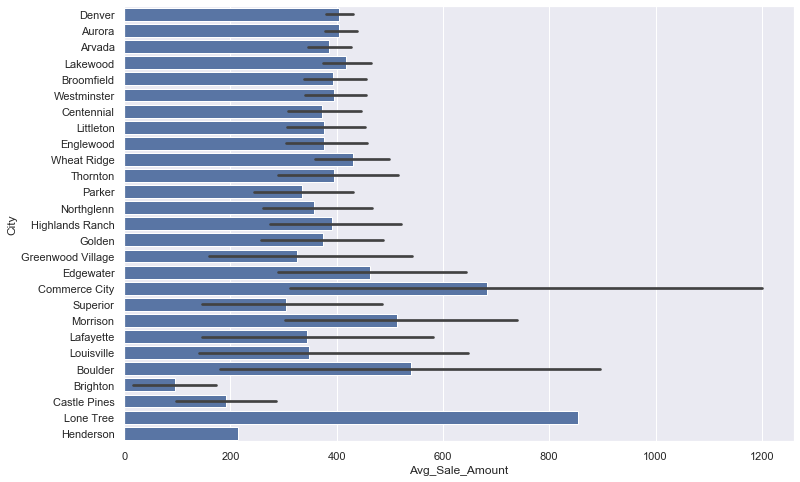

In [19]:
plt.figure(figsize=(12,8))
sns.barplot(data = data, y = 'City', x = 'Avg_Sale_Amount',color = base_color , order = city_order)

> The current customers are living in 27 different cities in Colorado. Denver, Aurora and Arbada are the top three cities where most customers live in. On the other hand, customers are rarely living in the cities: Castle Pine, Lone Tree and Henderson. The cities in the second plot are listed like in the first plot. At first, it seems the average sales amount of the customers in Denver is far less than that of the customers in Lone Tree, where second lowest number of current customer live. However we can notice that as the number of samples in each city are decreaseing the standard error of average sales amount is increasing (see the length of the black line on the bar plot). It is hard to generalize from the visualizations the effect of different cities on the average amount of sales. Thus, it is not included into the final model. 

### 4. Average Number Products Purchased

Text(0, 0.5, 'Average Sales Amount')

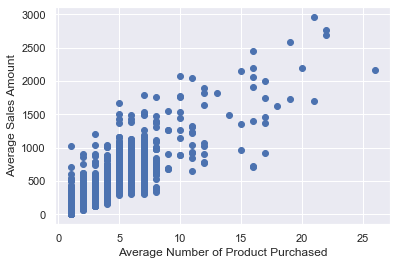

In [20]:
plt.scatter(data = data, x = 'Avg_Num_Products_Purchased', y = 'Avg_Sale_Amount')
plt.xlabel('Average Number of Product Purchased')
plt.ylabel('Average Sales Amount')

> "Avg_Num_Products_Purchased" is also a numeric varable, like the target variable "Avg_Sale_Amount". To analyse the relation between the two numeric variables, I plot the scatter plot. The number of purchased products has obviously a positive relationship with the average sales amount. The more number of products customers purchase, the larger amount of average sales the company could achieve. Thus, I included this feature into the predictive model. 

### 5. Number of Years as Customer

Text(0.5, 1.0, 'The Number of Customers in each group')

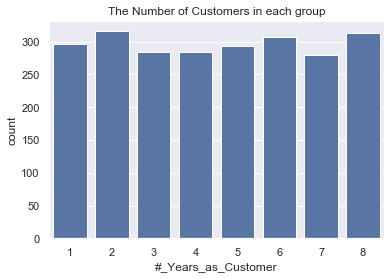

In [21]:
sns.countplot(data = data, x = '#_Years_as_Customer',color = base_color)
plt.title('The Number of Customers in each group')

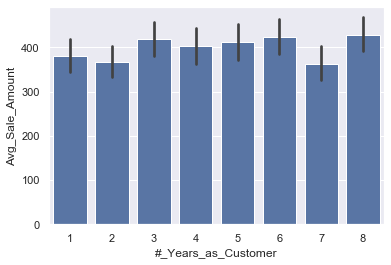

In [22]:
sns.barplot(data = data, x =  '#_Years_as_Customer' , y = 'Avg_Sale_Amount',color = base_color)

> The number of years as customer is also a numeric variable. Similar number of customers belong to each group). Also, the number of years as customer does not show any clear relationship with the target variable. In other words, the average sale amounts of individual groups are very much comparable across the groups, as the second plot of the section shows. Thus, increasing number of years as customer does not necessarily has an influence on the sales amount on average. The feature is not selected for predictive model. 

### 6. Responded to Last Catalog

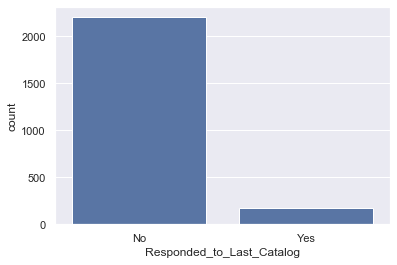

In [23]:
sns.countplot(data = data, x = 'Responded_to_Last_Catalog', color = base_color)

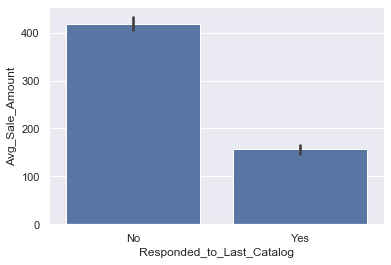

In [24]:
sns.barplot(data = data, x = 'Responded_to_Last_Catalog', y = 'Avg_Sale_Amount',color = base_color)

> It appears that there are far more customers do not respond to the last catalog than customers who responded. The average sales amount of not responded customers are larger than that of responded customers. Note that "Responded_to_Last_Catalog" is a dummy variable. Dummy variable has always linear relatonship with its target variable by definition. So, we can include it to the predictive linear model. However, the new customer dataset we need to predict sales includes all of the fields from "P1_Customers.xlsx" except for "Responded_to_Last_Catalog" so this variable cannot be used in the linear regression model since it could not be applied to the mailing list data set. For this reason, it is not included to the linear model. 

<a id='Analysis'></a>
## Data Analysis 

In [25]:
# Make a copy of an original dataset, to drop additional columns based on the previous exploration.
data_mod=data.copy()
data_mod.drop(['Customer_ID','Store_Number','City', 'Responded_to_Last_Catalog', '#_Years_as_Customer'], axis = 1, inplace = True) 

In [26]:
data_mod.head() # Now, we have three columns in the dataset.

,Customer_Segment,Avg_Sale_Amount,Avg_Num_Products_Purchased
0,Store Mailing List,227.90,1
1,Store Mailing List,55.00,1
2,Store Mailing List,212.57,1
3,Store Mailing List,195.31,1
4,Store Mailing List,110.55,1


In [27]:
data_v2=pd.get_dummies(data_mod, drop_first = True) # Make the categorical variable (Customer_Segment) to dummy variable

In [28]:
data_v2.head()

,Avg_Sale_Amount,Avg_Num_Products_Purchased,Customer_Segment_Loyalty Club Only,Customer_Segment_Loyalty Club and Credit Card,Customer_Segment_Store Mailing List
0,227.90,1,0,0,1
1,55.00,1,0,0,1
2,212.57,1,0,0,1
3,195.31,1,0,0,1
4,110.55,1,0,0,1


In [29]:
target = data_v2['Avg_Sale_Amount']
predictors_without_intercept= data_v2.drop(['Avg_Sale_Amount'],axis =1)

In [30]:
predictors = sm.add_constant(predictors_without_intercept)

In [31]:
results = sm.OLS(target,predictors).fit()

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     3040.
Date:                Sun, 04 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:57:21   Log-Likelihood:                -15061.
No. Observations:                2375   AIC:                         3.013e+04
Df Residuals:                    2370   BIC:                         3.016e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                           303.4635     10.576     28.694      0.000     282.725     324.202
Avg_Num_Products_Purchased                       66.9762      1.515     44.208      0.000      64.005      69.947
Customer_Segment_Loyalty Club Only             -149.3557      8.973    -16.645      0.000    -166.951    -131.760
Customer_Segment_Loyalty Club and Credit Card   281.8388     11.910     23.664      0.000     258.484     305.194
Customer_Segment_Store Mailing List            -245.4177      9.768    -25.125      0.000    -264.572    -226.263
==============================================================================
Omnibus:                      359.638   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4770.580
Skew:                           0.232   Prob(JB):                         0.00
Kurtosis:                       9.928   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> 1. Final Model <br>
"Average Number of purchased products” and “Customer_Segment” are included in the final predictive linear model The Best Linear Regression Equation is as follows:<br><br>
**Avg_Sale_Amount** =<br> 303.46 + 66.98* **Avg_Num_Products_Purchased**<br> + 0* **Customer_Segment_Credit Card Only** <br>– 149.36* **Customer_Segment_Loyalty Club Only** <br>+ 281.84* **Customer_Segment_Loyalty Club and Credit Card** <br>- 245.42* **Customer_Segment_Store Mailing List**

> 2. Model Justification & Validation 
    - The R-squared value of the linear regression model is 0.837. This indicates that 83.7% of the data can be explained by the above-mentioned linear model.
    - F-statistic values 3040.00 and the associated p-value is close to zero. This implies that the group of the predictor variables reliably predicts the target variable.
    - The p-values of each predictor variable are very low (very close to 0). Obviously, the values are less than the cut-off value 0.05. This indicates that each explanatory variable is statistically significant.
    - Therefore, the linear model is valid, and the results are reliable.

<a id='Conclusion'></a>
## Conclusion 

> To make a recommendation for the business decision, I calculate the expected profits by sending the new catalogs to new customers. 

In [33]:
# Load the mailing list of new customers
mail_list = pd.read_excel('p1-mailinglist.xlsx') 

In [34]:
mail_list.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer,Score_No,Score_Yes
0,A Giametti,Loyalty Club Only,2213,5326 S Lisbon Way,Centennial,CO,80015,105,3,0.2,0.694964,0.305036
1,Abby Pierson,Loyalty Club and Credit Card,2785,4344 W Roanoke Pl,Denver,CO,80236,101,6,0.6,0.527275,0.472725
2,Adele Hallman,Loyalty Club Only,2931,5219 S Delaware St,Englewood,CO,80110,101,7,0.9,0.421118,0.578882
3,Alejandra Baird,Loyalty Club Only,2231,2301 Lawrence St,Denver,CO,80205,103,2,0.6,0.694862,0.305138
4,Alice Dewitt,Loyalty Club Only,2530,5549 S Hannibal Way,Centennial,CO,80015,104,4,0.5,0.612294,0.387706


In [35]:
mail_list_v1 = mail_list[['Customer_Segment', 'Avg_Num_Products_Purchased', 'Score_Yes']]

In [36]:
mail_list_v1.head()

,Customer_Segment,Avg_Num_Products_Purchased,Score_Yes
0,Loyalty Club Only,3,0.305036
1,Loyalty Club and Credit Card,6,0.472725
2,Loyalty Club Only,7,0.578882
3,Loyalty Club Only,2,0.305138
4,Loyalty Club Only,4,0.387706


In [37]:
mail_mod=pd.get_dummies(mail_list_v1, drop_first = True) 
mail_mod.head()

,Avg_Num_Products_Purchased,Score_Yes,Customer_Segment_Loyalty Club Only,Customer_Segment_Loyalty Club and Credit Card,Customer_Segment_Store Mailing List
0,3,0.305036,1,0,0
1,6,0.472725,0,1,0
2,7,0.578882,1,0,0
3,2,0.305138,1,0,0
4,4,0.387706,1,0,0


In [38]:
mail_mod['predicted_sales']= 303.46 + 66.98*mail_mod['Avg_Num_Products_Purchased'] - 149.36*mail_mod['Customer_Segment_Loyalty Club Only']
+ 281.84*mail_mod['Customer_Segment_Loyalty Club and Credit Card'] - 245.42*mail_mod['Customer_Segment_Store Mailing List']


0        0.00
1      281.84
2        0.00
3        0.00
4        0.00
        ...  
245      0.00
246      0.00
247      0.00
248      0.00
249      0.00
Length: 250, dtype: float64

In [39]:
mail_mod['Expected_Revenue'] = mail_mod['predicted_sales']*mail_mod['Score_Yes']
# Score_Yes: The probability that the customer WILL respond to the catalog and make a purchase

In [40]:
mail_mod.head()

,Avg_Num_Products_Purchased,Score_Yes,Customer_Segment_Loyalty Club Only,Customer_Segment_Loyalty Club and Credit Card,Customer_Segment_Store Mailing List,predicted_sales,Expected_Revenue
0,3,0.305036,1,0,0,355.04,108.299913
1,6,0.472725,0,1,0,705.34,333.431525
2,7,0.578882,1,0,0,622.96,360.620237
3,2,0.305138,1,0,0,288.06,87.897998
4,4,0.387706,1,0,0,422.02,163.619625


In [41]:
total_exp_rev= mail_mod.Expected_Revenue.sum().round(2)
total_exp_rev

46518.78

In [42]:
total_exp_profit= total_exp_rev*0.5-6.5* 250
total_exp_profit

21634.39

> The company should send this year’s catalog to these new customers. According to the predictive analysis, the expected profit is  USD 21,634.39, assuming that the catalog is sent to the 250 new customers. The expected profit contribution is higher than USD 10,000 which is the cut-off suggested by the management. The expected profit is calculated according to the following steps.<br>
Using the above-mentioned regression equation, the average sales amounts of the 250 new customers are predicted. Then the predicted sales amounts are multiplied with the probability that each customer will buy the catalog. By doing so, I obtained the expected
revenue from each new customer. The aggregation value of each expected revenues is USD 46,518.78. After multiplying it by
the average gross margin (50%), I subtracted the all costs of catalog for the 250 customers. After all I ended up with the expected profit amount: USD 21,634.39. 
    USD 46,518.78 (The sum of expected revenue) <br>* 50% (The average gross margin) <br>- USD 6.5* 250(The total costs of 250 catalogs) = 
    USD 21,634.39 (The expected profit contribution)

> **Findings:** When assuming this year’s catalog is sent to these 250 customers, the expected profit from the new catalog is $ 21,634.39.